<a href="https://colab.research.google.com/github/burning-river/epithelium_segmentation/blob/main/make_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataname="epistroma"

patch_size=500 # size of patches extracted from the original image of size (1000 x 1000 x 3)
stride_size=250 # stride/jump between patches
mirror_pad_size=500 # number of pixels padded to the edges of the image. This allows edges to be segmented.
test_set_size=.1
resize=1 # set to 1 if no resizing needed. If image is 40X and needs to be downsized, set resize to 0.25 or 0.50.
max_patches = int(1E2)
classes=[0,1]

**Key Concept:** Patch size should neither be too small (due to lack of context) or too large (requires more training parameters and time).

In [ ]:
import torch
import tables

import os,sys
import glob

import PIL
import numpy as np

import cv2
import matplotlib.pyplot as plt

from sklearn import model_selection
import sklearn.feature_extraction.image
import random
from matplotlib.figure import Figure

random_state = 42

In [ ]:
img_dtype = tables.UInt8Atom() # datatype of the images and masks
filenameAtom = tables.StringAtom(itemsize=255) # max size of filename

In [ ]:
path = os.getcwd()+'/drive/MyDrive/dl_tutorial/epithelium/epi'
os.chdir('/content/drive/MyDrive/dl_tutorial/epithelium/epi')

In [ ]:
def extract_patch(file, interp_method, max_patches = max_patches, random_state = random_state):
  '''
  This function reads image file and creates patches based on the interpolation method.
  Args: file: input image/mask,
        interp_method: interpolation method. Important only if image/mask is resized,
        max_patches = no. of patches to be extracted,
        random_state = seed for random number generator.
  Returns: patches extracted from the image/mask.
  '''
  # cv2 loads images in BGR format. Therefore converting it to RGB
  img=cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB)
  # resize using scaling factor instead of size/dimension
  img = cv2.resize(img,(0,0),fx=resize,fy=resize, interpolation=interp_method)
  # padding image using mirroring for edges to be segmented
  img = np.pad(img, [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size), (0, 0)], mode="reflect")
  # extracting patches
  img_out=sklearn.feature_extraction.image.extract_patches_2d(img,(patch_size,patch_size), max_patches=max_patches, random_state = random_state)

  return img_out

## **Visualizations**

Let's look at a few examples of patches created.

In [ ]:
fname = '10260_00022_mask.png'
mask_img = path+"/masks/"+fname
mask_out = extract_patch(mask_img, PIL.Image.BICUBIC)

original_img = path+"/original/"+os.path.basename(fname).replace("_mask.png",".tif")
original_out = extract_patch(original_img, PIL.Image.BICUBIC)

original_img_arr = cv2.imread(original_img)
print(f'Original Image size: {original_img_arr.shape}', f'\nPatch size: {original_out.shape[1:]}')

Original Image size: (1000, 1000, 3) 
Patch size: (500, 500, 3)


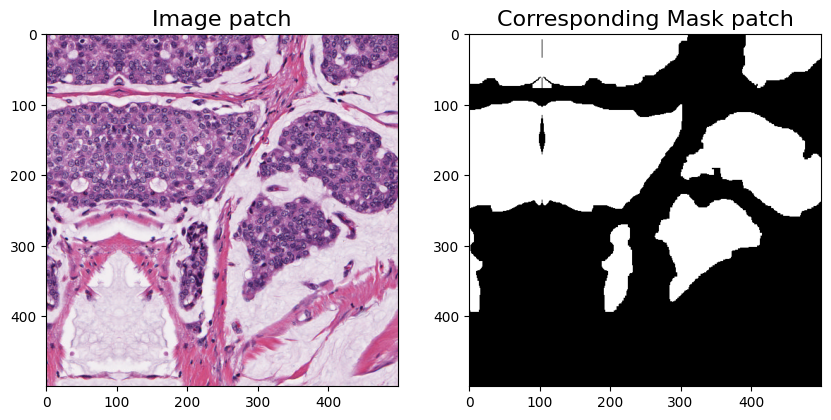

In [ ]:
fig = Figure(figsize=(10,5))
fontsize=16
ax = fig.add_subplot(1,2,1)
i = random.randint(0, max_patches - 1)
ax.set_title('Image patch',fontsize=fontsize)
ax.imshow(original_out[i])

ax = fig.add_subplot(1,2,2)
ax.set_title('Corresponding Mask patch',fontsize=fontsize)
ax.imshow(mask_out[i])
fig

**Key concept:** Train and test splitting must be done at a patient level. 2 different patches from the same patient would almost look alike. Therefore, if the network trains on one patch from a patient, it will most likely perform well on the 2nd patch from the same patient. This is an example of overfitting. The network will perform well on the patch from the patient it has already trained on but will not generalize well on a newer patient it hasn't trained on.

In [ ]:
files=glob.glob(path+'/masks/*.png') # list containing filenames of all masks

phases={}
indices = list(model_selection.ShuffleSplit(n_splits=1,test_size=test_set_size).split(files)) # split the files into train and test set only once
phases["train"],phases["val"] = indices[0][0], indices[0][1] # get indices for train and test set

imgtypes=["img","mask"]

In [ ]:
tables.Filters?

In [ ]:
hdf5_file = tables.open_file(f"{path}/{dataname}_train.pytable", mode='w')
hdf5_file.create_earray?

In [ ]:
storage={}

block_shape={}
block_shape["img"]= np.array((patch_size,patch_size,3)) # size of patch in RGB scale
block_shape["mask"]= np.array((patch_size,patch_size)) # size of mask in 1 dimension

filters=tables.Filters(complevel=6, complib='zlib') # image compression filters

for phase in phases.keys():
    print(phase)

    totals=np.zeros((2,len(classes)))
    totals[0,:]=classes

    hdf5_file = tables.open_file(f"{path}/{dataname}_{phase}.pytable", mode='w') # open a hdf5 Python table
    # earray: extendable array, means one doesn't have to specify size of array before righting to it.
    # number of patches is variable, therefore earray is suitable.
    storage["filename"] = hdf5_file.create_earray(hdf5_file.root, 'filename', filenameAtom, (0,)) # create an earray to store filenames

    for imgtype in imgtypes:
        # define parameters of the image/mask array such as datatype (int/float), array size, compression type
        storage[imgtype]= hdf5_file.create_earray(hdf5_file.root, imgtype, img_dtype,
                                              shape=np.append([0],block_shape[imgtype]),
                                              chunkshape=np.append([1],block_shape[imgtype]),
                                              filters=filters) # chunkshape determines the number of images that are compressed at a time.
        # larger the chunkshape, lesser the compression time but more the retreival time during training.
        # smaller chunkshape of [1] allows better retreival of any image at random.
    for filei in phases[phase]: # iterating over images in training and validation sets
        fname=files[filei]

        print(fname)

        imgtype = 'img' # first extracting patches from image
        img_file = path+"/original/"+os.path.basename(fname).replace("_mask.png",".tif")
        # Extracting patches with specified interpolation method if the patches are resized.
        io_arr_out = extract_patch(img_file, PIL.Image.BICUBIC)
        # storing the patches in a list in storage
        storage[imgtype].append(io_arr_out)

        imgtype = 'mask' # next extracting matching patches from mask
        io=cv2.imread(fname)/255 # the image is loaded as {0,255}, but we'd like to store it as binary values {0,1}

        # calculating number of background and foreground pixels in all patches.
        for i,key in enumerate(classes):
            totals[1,i]+=sum(sum(io[:,:,0]==key))

        # Using nearest neighbor interpolation for masks otherwise we'll get values between 0 and 1
        io_arr_out = extract_patch(fname, PIL.Image.NEAREST)
        # only need 1 channel for mask data. squeeze() removes extra axes of length 1
        storage[imgtype].append(io_arr_out[:,:,:,0].squeeze())

    # adding the corresponding filename/source for each patch to the storage array
    storage["filename"].append([fname for x in range(io_arr_out.shape[0])])
    # storing the number of pixels
    npixels=hdf5_file.create_carray(hdf5_file.root, 'numpixels', tables.Atom.from_dtype(totals.dtype), totals.shape)
    npixels[:]=totals
    hdf5_file.close()

train
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12911_00005_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/9043_00045_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/10278_00006_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12947_00004_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/10261_00002_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12626_00016_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12875_00002_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12881_00009_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/10286_00014_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12884_00018_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/9023_00012_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12819_00004_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/9227_00006_mask.